# <font color=green>LivingEarth Australia - FAO LCCS Level 3</font>

### An environmental layers testing framework for the FAO land cover classification system

The purpose of this notebook is to provide an easy-to-use method for testing environmental layers to use for classification and seeing how changes to particular layers effect the final Land Cover Classification. You can easily test with different environmental layer inputs, and different locations. 

This code defines 5 variables to contain the binary layers required to reach a level 3 classification:
1. <font color=blue>**vegetat_veg_cat:**</font> Vegetated / Non-Vegetated 
2. <font color=blue>**aquatic_wat_cat:**</font> Aquatic / Terrestrial 
3. <font color=blue>**cultman_agr_cat:**</font> Natural Vegetation / Crop or Managed Vegetation
4. <font color=blue>**artific_urb_cat:**</font> Natural Surfaces / Artificial Surfaces
5. <font color=blue>**artwatr_wat_cat:**</font> Natural Water / Artificial Water

Whilst this example is using open data cube to load the required data, it can be loaded from anywhere - so long as all input layers cover the same geographic region and are defined in a correctly labelled dataset, before being passed to the classification code.

### **Import modules**

In [1]:
import numpy
import xarray
import rasterio
from matplotlib import pyplot
import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

# must specific lccs_dev environment for MADs and mangrove datasets
dc = datacube.Datacube(env='lccs_dev', app="level3")

#import le_lccs modules
import sys
sys.path.append("../../../livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest
from le_lccs.le_classification import lccs_l3

### **Define are of interest to be loaded**

In [2]:
# # Ayr
# x = (1500000, 1600000)
# y = (-2200000, -2100000)
# min_x = 1500000
# max_x = 1600000
# min_y = -2200000
# max_y = -2100000
# res_x = 100
# res_y = -100

# # Diamantina
# x = (800000, 900000)
# y = (-2800000, -2700000)
# min_x = 800000
# max_x = 900000
# min_y = -2800000
# max_y = -2700000
# res_x = 100
# res_y = -100

# # Gwydir
# x = (1600000, 1700000)
# y = (-3400000, -3300000)
# min_x = 1600000
# max_x = 1700000
# min_y = -3400000
# max_y = -3300000
# res_x = 100
# res_y = -100

# # Leichhardt
# x = (800000, 900000)
# y = (-2000000, -1900000)
# min_x = 800000
# max_x = 900000
# min_y = -2000000
# max_y = -1900000
# res_x = 100
# res_y = -100

# # Kakadu
# x = (0, 100000)
# y = (-1350000, -1250000)
# min_x = 0
# max_x = 100000
# min_y = -1350000
# max_y = -1250000
# res_x = 100
# res_y = -100

# # Hobart
# x = (1200000, 1300000)
# y = (-4800000, -4700000)
# min_x = 1200000
# max_x = 1300000
# min_y = -4800000
# max_y = -4700000
# res_x = 100
# res_y = -100

# Perth
x = (-1550000, -1450000)
y = (-3650000, -3550000)
min_x = -1550000
max_x = -1450000
min_y = -3650000
max_y = -3550000
res_x = 100
res_y = -100

# # Murray Valley
# x = (1100000, 1200000)
# y = (-4000000, -3900000)
# min_x = 1100000
# max_x = 1200000
# min_y = -4000000
# max_y = -3900000
# res_x = 100
# res_y = -100

# # Adelaide
# x = (550000, 650000)
# y = (-3850000, -3750000)
# min_x = 550000
# max_x = 650000
# min_y = -3850000
# max_y = -3750000
# res_x = 100
# res_y = -100

# # Lake Eyre
# x = (500000, 600000)
# y = (-3000000, -2900000)
# min_x = 500000
# max_x = 600000
# min_y = -3000000
# max_y = -2900000
# res_x = 100
# res_y = -100

# # Blue mountains
# x = (1600000, 1700000)
# y = (-3900000, -3800000)
# min_x = 1600000
# max_x = 1700000
# min_y = -3900000
# max_y = -3800000
# res_x = 100
# res_y = -100

# # Australian Alps
# x = (1400000, 1500000)
# y = (-4100000, -4000000)
# min_x = 1400000
# max_x = 1500000
# min_y = -4100000
# max_y = -4000000
# res_x = 100
# res_y = -100

# # Collier Range
# x = (-1300000, -1200000)
# y = (-2700000, -2600000)
# min_x = -1300000
# max_x = -1200000
# min_y = -2700000
# max_y = -2600000
# res_x = 100
# res_y = -100

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)
# min_x = 600000
# max_x = 700000
# min_y = -3950000
# max_y = -3850000
# res_x = 100
# res_y = -100

# # Brisbane
# x = (2000000, 2100000)
# y = (-3200000, -3100000)
# min_x = 2000000
# max_x = 2100000
# min_y = -3200000
# max_y = -3100000
# res_x = 100
# res_y = -100

# # Dundas
# x = (-1000000, -900000)
# y = (-3650000, -3550000)
# min_x = -1000000
# max_x = -900000
# min_y = -3650000
# max_y = -3550000
# res_x = 100
# res_y = -100

res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")
sensor = 'ls8'
query =({'x':x,
        'y':y,
        'crs':crs,
        'resolution':res})

## <font color=blue>Create environmental layers</font>

### 1. Vegetated / Non-Vegetated

   * **Primarily Vegetated Areas**:
   This class applies to areas that have a vegetative cover of at least 4% for at least two months of the year, consisting of Woody (Trees, Shrubs) and/or Herbaceous (Forbs, Graminoids) lifeforms, or at least 25% cover of Lichens/Mosses when other life forms are absent.
      
   * **Primarily Non-Vegetated Areas**:
   Areas which are not primarily vegetated.
 

Fractional cover (FC) is used to distinguish between vegetated and not vegetated. 
http://data.auscover.org.au/xwiki/bin/view/Product+pages/Landsat+Fractional+Cover
<br>We are using the 90th annual percentile for both Photosyntheic (PV) and Non-photosynthetic (NPV) vegetation. This removes noise and outliers and gives a robust maximum annual value. A threshold is then applied where PV or NPV is greater than 50%, the rationale being that if a pixel is greater than 50% PV or NPV we can be confident that it is likely to be vegetated. In addition, a maximum threshold value is given to NPV as non-photosynthetic vegetation and bare soil (BS) fractions can be unreliable at maximum values due to inherent issues with unmixing NPV and BS signatures.

<font color=red>**TODO:**</font> need to calculate number of observations for annual time series to define vegetation correctly as in FAO guidelines. This will likely be similar to WOfS wet/clear obervations but for FC where PV or NPV is greater than 50% for 60 days per year

In [3]:
# Load data from datacube
fc_ann = dc.load(product="fc_percentile_albers_annual", 
                 measurements=["PV_PC_90", "NPV_PC_90", "BS_PC_90"],
                 time=time, **query)
fc_ann = masking.mask_invalid_data(fc_ann)

In [4]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat = ((fc_ann["PV_PC_90"] >= 50) | ((fc_ann["NPV_PC_90"] >= 50) & (fc_ann["NPV_PC_90"] <= 80)))

# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat.to_dataset(name="vegetat_veg_cat").squeeze().drop('time')

In [5]:
# Plot output
# vegetat_veg_cat_ds["vegetat_veg_cat"].plot.imshow(figsize=(6, 5))

### 2. Aquatic / Terrestrial

   * **Primarily Vegetated, Terrestrial**: The vegetation is influenced by the edaphic substratum
   * **Primarily Non-Vegetated, Terrestrial**: The cover is influenced by the edaphic substratum
   * **Primarily Vegetated, Aquatic or regularly flooded**: The environment is significantly influenced by the presence of water over extensive periods of time. The water is the dominant factor determining natural soil development and the type of plant communities living on its surface
   * **Primarily Non-Vegetated, Aquatic or regularly flooded**: Permanent or regularly flood aquatic areas
   

Water Observations from Space (WOfS) is used to distinguish aquatic and terrestrial areas.
https://www.sciencedirect.com/science/article/pii/S0034425715301929?via%3Dihub
<br> A threshold of 20% is applied for the annual summary dataset to remove flood events not indicative of the landscape.
<br>The Intertidal Extents Model (ITEM) and Mangrove layer are also used for relevant coastal landscapes.

<font color=red>**TODO:**</font> notebook fails if area does not have datasets for ITEM and mangroves therefore currently commented out. Need to write a pass if no data is found

In [6]:
# Load data from datacube
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], 
                     time=time, **query)
wofs_ann = masking.mask_invalid_data(wofs_ann)

# item = dc.load(product="item_v2", measurements=["relative"], 
#                      time=time, **query)
# item = masking.mask_invalid_data(item)
# item = item.squeeze().drop('time')

# mangrove = dc.load(product="mangrove_extent_cover_albers", measurements=["extent"], 
#                      time=time, **query)
# mangrove = masking.mask_invalid_data(mangrove)

In [7]:
# Create binary layer representing aquatic (1) and terrestrial (0)

aquatic_wat = ((wofs_ann["frequency"] >= 0.2))

# For coastal landscapes use the following
# aquatic_wat = ((wofs_ann["frequency"] >= 0.2) | ((item["relative"] >= 2) & (item["relative"] <= 8)) | (mangrove["extent"] == 1))

# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat.to_dataset(name="aquatic_wat_cat").squeeze().drop('time')             

In [8]:
# Plot output
# aquatic_wat_cat_ds["aquatic_wat_cat"].plot.imshow(figsize=(6, 5))

### 3. Natural Vegetation / Crop or Managed Vegetation

   * **Primarily Vegetated, Terrestrial, Artificial/Managed**: Cultivated and Managed Terrestrial Areas
   * **Primarily Vegetated, Terrestrial, (Semi-)natural**: Natural and Semi-Natural Vegetation
   * **Primarily Vegetated, Aquatic or Regularly Flooded, Artificial/Managed**: Cultivated Aquatic or Regularly Flooded Areas
   * **Primarily Vegetated, Aquatic or Regularly Flooded, (Semi-)natural**: Natural and Semi-Natural Aquatic or Regularly Flooded Vegetation

Median Absolute Deviation (MADs) is used to distinguish between natural and cultivated areas. Measurements include euclian distance (edev), spectral distance (sdev), and bray-curtis distance (bcdev) of pixel values from the annual median. <br>https://ieeexplore.ieee.org/abstract/document/8518312
<br>A log function is applied to normalise. 

<font color=red>**TODO:**</font> need to explore workflows for differentiating cultivated areas that are statistically robust. Some suggestions include ostu, random forests

In [9]:
# Load data from datacube
mads = dc.load(product=sensor +"_nbart_tmad_annual", time=time, **query)
mads = masking.mask_invalid_data(mads)

In [10]:
# Normalise measurements using log function
log_edev = numpy.log(1/mads["edev"])
log_sdev = numpy.log(1/mads["sdev"])
log_bcdev = numpy.log(1/mads["bcdev"])

# Create binary layer representing cultivated (1) and natural (0)
cultman = (((log_edev >= 1.5) & (log_edev <= 2.5)) & ((log_sdev >= 3) & (log_sdev <= 6)) & ((log_bcdev >= 1) & (log_bcdev <= 4)))

# Convert to Dataset and add name
cultman_agr_cat_ds = cultman.to_dataset(name="cultman_agr_cat").squeeze().drop('time')

In [11]:
# Plot output
# cultman_agr_cat_ds["cultman_agr_cat"].plot.imshow(figsize=(6, 5))

### 4. Natural Surfaces / Artificial Surfaces

   * **Primarily non-vegetated, Terrestrial, Artificial/managed**: Areas that have an artificial cover as a result of human activities such as construction, extraction or waste disposal
   * **Primarily non-vegetated, Terrestrial, (Semi-)natural**: Bare areas that do not have an artificial cover as a result of human activities. These areas include areas with less than 4% vegetative cover. Included are bare rock areas, sands and deserts   

Current using either Normalized Difference Built-up Index (NDBI) or Median Absolute Deviation (MADs). Both have issues distinguishing bare areas, particularly coastal dunes and other sandy areas, as well as industrial areas with highly reflective roofs.

<font color=red>**TODO:**</font> need to explore workflows for differentiating artificial areas that are statistically robust. Richard suggested that artificial surfaces needs to have a quantifiable value (i.e. %cover) that can be achieved using a master layer for artificial surfaces (i.e. GA - GEODATA TOPO) and defining relationships between %cover in each pixel and NDVI or MADs

In [12]:
# Load data
geomedian = dc.load(product=sensor + "_nbart_geomedian_annual", time=time, **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')

In [13]:
# Calculate NDBI
NDBI = ((geomedian.swir1 - geomedian.nir) / (geomedian.swir1 + geomedian.nir))

In [14]:
# Create binary layer representing urban (1) and baresoil (0)

urban = ((NDBI > -0.1) & (NDBI < 0.05)) | ((fc_ann["BS_PC_90"] >= 90) & (fc_ann["BS_PC_90"] <= 200))
# urban = (((log_edev >= 2) & (log_edev <= 3.5)) & ((log_sdev >= 6) & (log_sdev <= 8)) & ((log_bcdev >= 2) & (log_bcdev <= 4)))

# Convert to Dataset and add name
artific_urb_cat_ds = urban.to_dataset(name="artific_urb_cat").squeeze().drop('time')

In [15]:
# Plot output
# artific_urb_cat_ds["artific_urb_cat"].plot.imshow(figsize=(6, 5))

### 5. Natural Water / Artificial Water

   * **Primarily non-vegetated, Aquatic or Regularly Flooded, Artificial/managed**: areas that are covered by water due to the construction of artefacts such as reservoirs, canals, artificial lakes, etc.
   * **Primarily non-vegetated, Aquatic or Regularly Flooded, (Semi-)natural**: areas that are naturally covered by water, such as lakes, rivers, snow or ice

As differentiating between natural and artificial waterbodies using only satellite imagery is extremely difficult, here we use a static layer. Australian Hydrological Geospatial Fabric (Geofabric) is a dataset of hydrological features derived from manually interpreted topographic map grids. It classifies the land in terms of:  
0: Unclassified, 1: CanalArea, 2: Flat, 3: ForeshoreFlat, 4: PondageArea, 5: RapidArea, 6: WatercourseArea, 7: Lake, 8: Reservoir, 9: Swamp.
<br>Here, CanalArea & Reservoir are used to define artificial water.

<font color=red>**TODO:**</font> need to consider shape functions such as object-based analysis. RSGISlib has some of this functionality and is worth trying

In [16]:
# Load data
var_file = "/g/data/u46/wofs/confidence/geoFabric/geofabric.tif"
var_name = "features"

import_obj = gridded_ingest.LEIngestGDAL(min_x, max_x, min_y, max_y,res_x,res_y, crs)
geofabric = import_obj.read_to_xarray(var_file, var_name)

In [17]:
# Create binary layer representing artificial water (1) and natural water (0)
artwatr_wat_cat = ((geofabric["features"] == 1) | (geofabric["features"] == 8))

# Convert to Dataset and add name
artwatr_wat_cat_ds = artwatr_wat_cat.to_dataset(name="artwatr_wat_cat")

In [18]:
# Plot output
# artwatr_wat_cat_ds["artwatr_wat_cat"].plot.imshow(figsize=(6, 5))

### **Collect environmental variables into array for passing to classification system**

In [19]:
variables_xarray_list = []
variables_xarray_list.append(vegetat_veg_cat_ds)
variables_xarray_list.append(aquatic_wat_cat_ds)
variables_xarray_list.append(cultman_agr_cat_ds)
variables_xarray_list.append(artific_urb_cat_ds)
variables_xarray_list.append(artwatr_wat_cat_ds)

## <font color=blue>Classification</font>

**The LCCS classificaition is hierachial. The 8 classes are shown below**

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [20]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

In [21]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [22]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset(
    {"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
     "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
     "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])

## <font color=blue>Results</font>

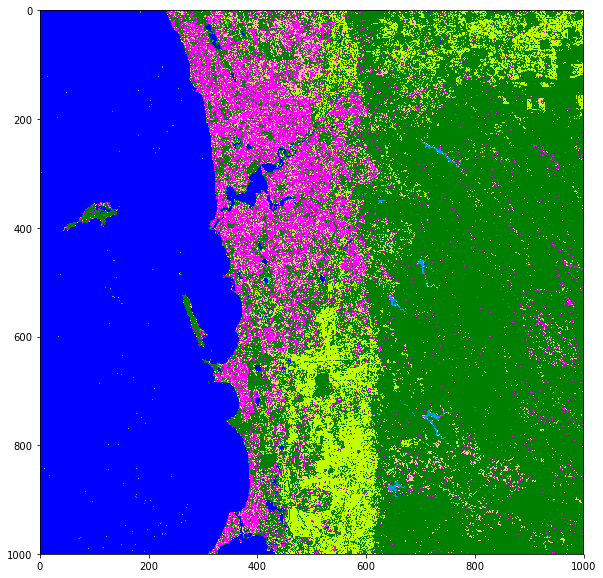

In [23]:
# To check the results for level 3 use colour_lccs_level3 to get the colour scheme.
pyplot.figure(figsize=(12, 10))
red, green, blue, alpha = lccs_l3.colour_lccs_level3(level3)
pyplot.imshow(numpy.dstack([red, green, blue, alpha]))

### **Save results to geotiff**

In [24]:
# # Write out
# output_rgb_file_name = "level3_test.tif"
# out_file_transform = [res_x, 0, min_x, 0, res_y, max_y]
# output_x_size = int((max_x - min_x)/res_x)
# output_y_size = int((min_y - max_y)/res_y)

# # Write RGB colour scheme out
# rgb_dataset = rasterio.open(output_rgb_file_name, 'w', driver='GTiff',
#                             height=output_y_size, width=output_x_size,
#                             count=3, dtype=level3.dtype,
#                             crs=crs, transform=out_file_transform)
# rgb_dataset.write(red, 1)
# rgb_dataset.write(green, 2)
# rgb_dataset.write(blue, 3)
# rgb_dataset.close()